In [8]:
using QuantumAnnealingTools
# This package is needed to load actual ODE solvers. Without it, the ODE solvers won't work.
using OrdinaryDiffEq
# We need to plot our results for the demo
using Plots

# Single Qubit Example

In this example, we will try to recreate the example in this paper: [Decoherence in adiabatic quantum computation](https://arxiv.org/abs/1503.08767).
The Hamiltonian is
\begin{equation}
H(s) = -\frac{1}{2}(1-s)\sigma_x - \frac{1}{2}s\sigma_z
\end{equation}
The following code block construct this Hamiltonian

In [9]:
H = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2)

DenseHamiltonian with Complex{Float64}
with size: (2, 2)

This package directly interacts with `Plots.jl`. We can look at the spectrum of the Hamiltonian by directly plotting the object

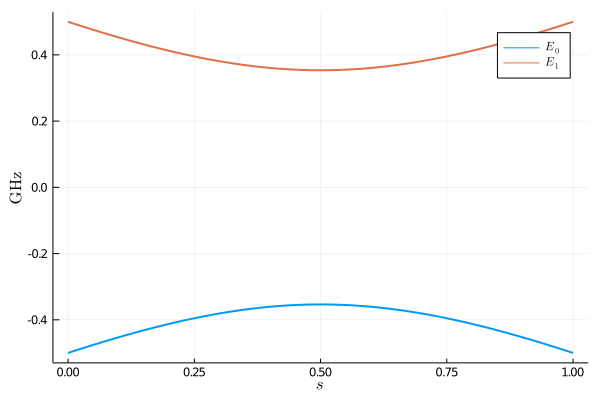

In [10]:
plot(H, 0:0.01:1, 2, linewidth=2)

## Unit ($h$ or $\hbar$)
There is a keyword argument `unit` for the constructor of any Hamiltonian object, whose default value is `:h`. This argument specifies the unit of other input arguments. For example, setting `unit` to `:h` means other input argument is in $\mathrm{GHz}$, while setting it to `:ħ` means the unit is in $2\pi\mathrm{GHz}$. To evaluate the value of Hamiltonian object at a given time, it is recommended to use `evaluate` function instead of directly calling the object. This will also return the value in the unit system of $h=1$.

In [11]:
H_h = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2, unit=:h)
H_ħ = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2, unit=:ħ)
println("Setting unit to :h")
@show evaluate(H_h, 0.5)
println("Setting unit to :ħ")
@show evaluate(H_ħ, 0.5);

Setting unit to :h
evaluate(H_h, 0.5) = Complex{Float64}[-0.25 + 0.0im -0.25 + 0.0im; -0.25 + 0.0im 0.25 + 0.0im]
Setting unit to :ħ
evaluate(H_ħ, 0.5) = Complex{Float64}[-0.039788735772973836 + 0.0im -0.039788735772973836 + 0.0im; -0.039788735772973836 + 0.0im 0.039788735772973836 + 0.0im]


Internally, this package use a unit system of $\hbar=1$. If we call `H_h` directly, we can see that the value is scaled by $2\pi$.

In [12]:
H_h(0.5)

2×2 Array{Complex{Float64},2}:
 -1.5708+0.0im  -1.5708+0.0im
 -1.5708+0.0im   1.5708+0.0im

## Annealing
The total Hamiltonian is
\begin{equation}
    H(s) = H_{\mathrm{S}}(s) + gS \otimes B + H_{\mathrm{B}}
\end{equation}
We denote $S$ the coupling and $\{gB, H_{\mathrm{B}}\}$ the bath.
### Coupling
For constant coupling operators, we can use constructor `ConstantCouplings`. Like the case of Hamiltonian, there will be a keyword argument `unit` to specify the input unit.

In [13]:
coupling = ConstantCouplings(["Z"])

ConstantCouplings with Array{Complex{Float64},2}
with string representation: ["Z"]

### Bath
A bath instance can be any object which implement three methods:
  1. Correlation function: `correlation(τ, bath)`
  2. Spectrum density: `γ(ω, bath)`
  3. Lamb shift: `S(ω, bath)`

Those three methods are required by Redfield/Adiabatic ME solvers. Currently we have built in support for Ohmic bath.
An Ohmic bath object can be created by

In [14]:
η = 1e-4
fc = 4
T = 16
bath = Ohmic(η, fc, T)

Ohmic bath instance:
η (unitless): 0.0001
ωc (GHz): 4.0
T (mK): 16.0

`info_freq` is a convenient function to convert each quantities into the same unit.

In [15]:
info_freq(bath)

ωc (GHz): 4.0
T (GHz): 0.33338579560200365


We can also directly plot the spectrum density of Ohmic bath

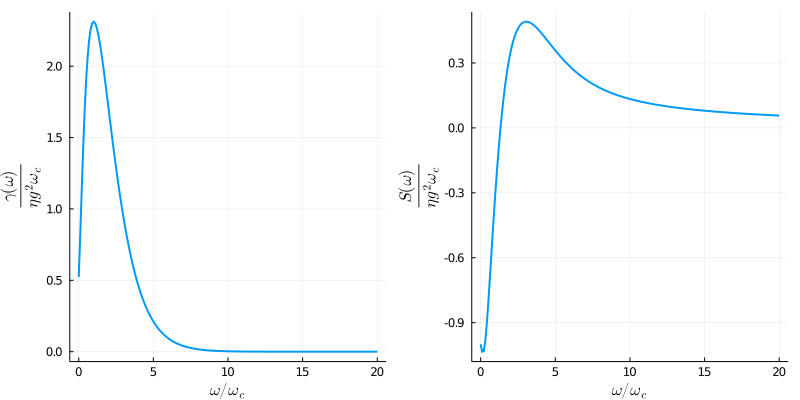

In [39]:
p1 = plot(bath, :γ, range(0,20,length=200), label="", size=(800, 400), linewidth=2)
p2 = plot(bath, :S, range(0,20,length=200), label="", size=(800, 400), linewidth=2)
plot(p1, p2, layout=(1,2), left_margin=3Plots.Measures.mm)

### Annealing

Finally, we can assemble the annealing object by

In [17]:
# Hamiltonian
H = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2, unit=:ħ)
# initial state
u0 = PauliVec[1][1]
# coupling
coupling = ConstantCouplings(["Z"], unit=:ħ)
# bath
bath = Ohmic(1e-4, 4, 16)
annealing = Annealing(H, u0; coupling=coupling, bath=bath)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)
bath: OhmicBath(0.0001, 25.132741228718345, 0.4773896944364562)

Because we want to compare our results to the [reference paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320), we need to set the unit to $\hbar=1$.

## Solvers
Currently there are several interface to the solvers which might be handy. The first one is the solver for Schrodinger equation.

In [18]:
@time sol = solve_schrodinger(annealing, 10*sqrt(2), alg=Tsit5(), abstol=1e-8, retol=1e-8);

 15.557809 seconds (51.68 M allocations: 3.004 GiB, 7.00% gc time)


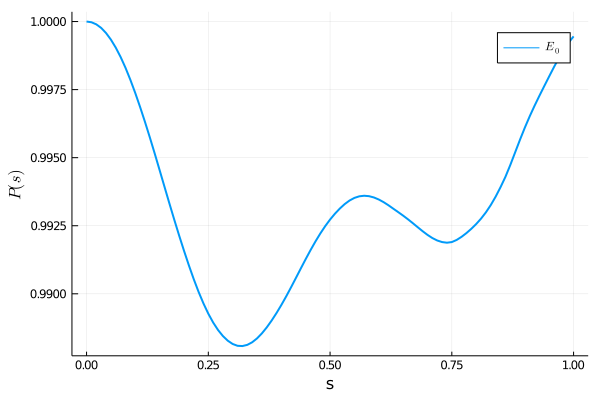

In [19]:
plot(sol, H, [1], 0:0.01:1, linewidth=2)

The solution is an `ODESolution` object in `DifferentialEquations.jl` package. More details for the interface can be found [here](http://docs.juliadiffeq.org/latest/basics/solution.html). The value of state vector at a given time can be obtained by directly calling the `ODESolution` object.

In [20]:
sol(0.5)

2-element Array{Complex{Float64},1}:
  -0.9060832238560463 + 0.18896473235029987im
 -0.34116199978721223 + 0.16407507819939743im

other interface includes

In [21]:
# You need to solve the unitary first before trying to solve Redfield equation
@time U = solve_unitary(annealing, 10*sqrt(2), alg=Tsit5(), abstol=1e-8, retol=1e-8);
@time solve_von_neumann(annealing, 10*sqrt(2), alg=Tsit5(), abstol=1e-8, retol=1e-8);

  5.092732 seconds (24.04 M allocations: 1.115 GiB, 6.89% gc time)
  2.674052 seconds (9.25 M allocations: 468.709 MiB, 5.03% gc time)


### Open System
#### Time dependent Redfield equation
The time depedent Redfield equation interface needs
  1. Annealing object
  2. Total annealing time
  3. Pre-calculated unitary
  
All the other keyword arguments in [solver options](http://docs.juliadiffeq.org/latest/basics/common_solver_opts.html) are supported. Currently, support for implicit methods are only for `solve_schrodinger`.

In [22]:
tf = 10*sqrt(2)
U = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-8, retol=1e-8);
sol = solve_redfield(annealing, tf, U; alg=Tsit5(), abstol=1e-8, retol=1e-8);

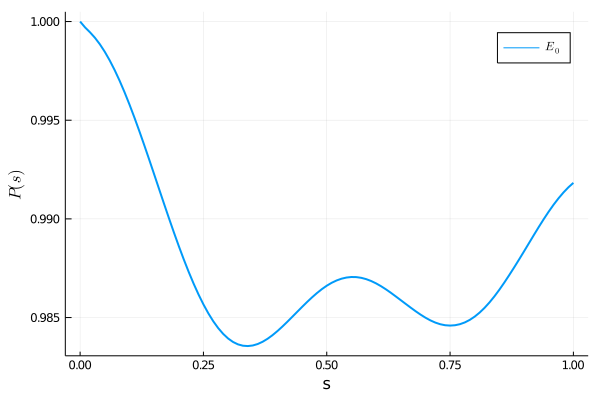

In [23]:
plot(sol, H, [1], 0:0.01:1, linewidth=2)

#### Adiabatic master equation
The adiabatic master equation interface needs
  1. Annealing object
  2. Total Annealing time

Besides other keyword arguments supported in `DifferentialEquations`, it is highly recommended to add the `ω_hint` keyword argument. By doing this, the solver will pre-compute the lamb shift $S(\omega)$ within given range to speed up the computation.

In [24]:
tf = 10*sqrt(2)
@time sol = solve_ame(annealing, tf; alg=Tsit5(), ω_hint=range(-6, 6, length=100), reltol=1e-8, abstol=1e-8);

  5.404257 seconds (19.08 M allocations: 960.606 MiB, 4.73% gc time)


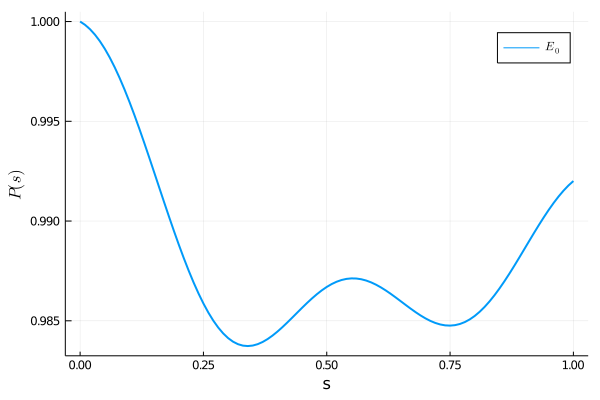

In [25]:
plot(sol, H, [1], 0:0.01:1, linewidth=2)

In [32]:
tf = 5000
@time sol_ame = solve_ame(annealing, tf; alg=Tsit5(), ω_hint=range(-6, 6, length=100), reltol=1e-8, abstol=1e-8);

  0.264478 seconds (2.26 M allocations: 163.845 MiB, 14.12% gc time)


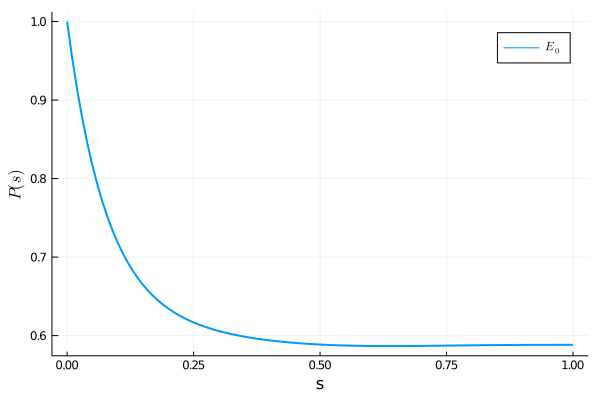

In [33]:
plot(sol_ame, H, [1], 0:0.01:1, linewidth=2)

The above results agree with Fig 2 of the [reference paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320).

#### Trajectory method for adiabatic master equation
The package also supports the trajectory method for AME. More details of this method can be found in this [paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.022116). The basic workflow is to create ODE [EnsembleProblem](https://docs.juliadiffeq.org/dev/features/ensemble/) via `build_ensemble_problem` interface. Then, the resulting ensemble problem can be solved by the native [Parallel Ensemble Simulations](https://docs.juliadiffeq.org/dev/features/ensemble/) interface of `DifferentialEquations.jl`. The following code block solves the same $t_f = 5000(ns)$ annealing above with 1000 trajectories.

In [28]:
tf = 5000
prob, callback = build_ensemble_problem(annealing, tf, :ame_trajectory, ω_hint=range(-6, 6, length=100))
sol = solve(prob, Tsit5(), EnsembleSerial(), trajectories=1000, reltol=1e-8, abstol=1e-8, callback=callback, saveat=range(0,1,length=100));

In [29]:
s_axis = range(0,1,length=100)
dataset = []
for s in s_axis
    w, v = eigen_decomp(H, s)
    push!(dataset, [abs2(normalize(so(s))' * v[:, 1]) for so in sol])
end

pop_mean = []
pop_rmse = []
for data in dataset
    p_mean = sum(data)/1000
    p_rmse = sqrt(sum((x)->(x-p_mean)^2, data))/1000
    push!(pop_mean, p_mean)
    push!(pop_rmse, p_rmse)
end

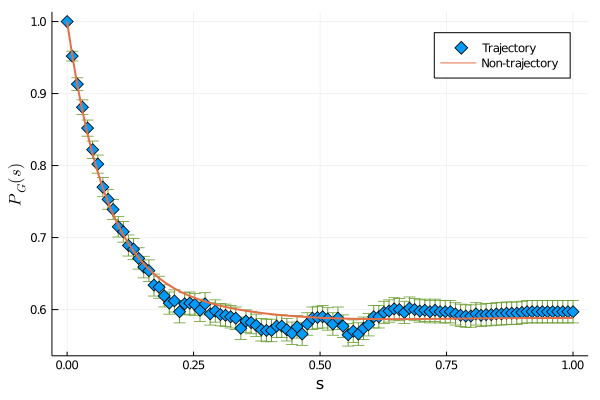

In [36]:
scatter(s_axis, pop_mean, marker=:d, yerror=pop_rmse, label="Trajectory", markersize=6)
plot!(sol_ame, H, [1], 0:0.01:1, linewidth=2, label="Non-trajectory")
xlabel!("s")
ylabel!(L"P_G(s)")